# Learning and inference with the task model

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import task_generation, task_model
import tqdm

# choose a subset of tasks to learn
task_list = ['PRO_D', 'PRO_M', 'ANTI_D', 'ANTI_M']
n_trials = 40  # number of trials. these will be evenly split between the tasks.
nx = 2  # possible values of x. Could be more than 2.
sigma = 0.1  # observational noise
p_stay = 0.95  # probability of staying in the same epoch
min_Te = 50  # minimum duration of each epoch
x_oracle = False  # whether or not to supply true x for each trial

np.random.seed(0)

trials, epoch_list = task_generation.generate_trials(
    task_list, n_trials, nx, sigma, p_stay, min_Te, trial_order='blocked')

nc = len(task_list)  # number of tasks in the dataset
nz = len(epoch_list)  # number of epoch types in the dataset

true_M, true_W, true_p0_z = task_generation.get_ground_truth(
    task_list, epoch_list, p_stay=p_stay, nx=nx)

num_epochs_each_task = [len(np.unique(task_generation.task_dict[task_type].\
                                      split('->'))) for task_type in task_list]

# store what a fixation epoch looks like
w_fixate = task_generation.make_delay_or_fixation_epoch(None, 1, 0, 0, d_stim=np.pi/2)
w_fixate = np.concatenate([w_fixate['s'], w_fixate['y']], axis=1)

LL_over_trials_across_time = np.zeros((n_trials, n_trials))

model = task_model.TaskModel(
    nc=nc, nz=nz, nx=nx, sigma=sigma, d=w_fixate.shape[-1],
    n_epochs_each_task=num_epochs_each_task,
    w_fixate=w_fixate)


inferred_z_during_learning = []
for itrial, trial in enumerate(trials):
    model.dynamic_initialize_W(trial)
    model.learn_single_trial(trial)
    LLs = []
    for _trial in trials:
        gamma, LL = model.infer(_trial, use_y=True)
        inferred_z_during_learning.append(gamma.sum(0).sum(0))
        LLs.append(LL)
    LL_over_trials_across_time[itrial] = np.array(LLs)


In [3]:
inferred_z_after_learning = []
for _, trial in enumerate(trials):
    gamma, LL = model.infer(trial, use_y=False)
    inferred_z_after_learning.append(gamma.sum(0).sum(0))

## Inferred posterior over z for an example trial

Text(0, 0.5, 'z')

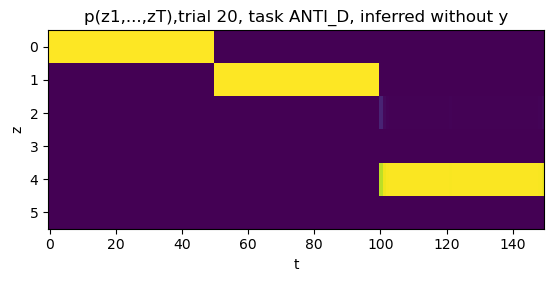

In [4]:
trial_ind = 20
plt.figure()
plt.imshow(inferred_z_after_learning[trial_ind], interpolation='none')
plt.gca().set_aspect(10)
plt.xlabel('t')
plt.title(f'p(z1,...,zT),trial {trial_ind}, task {task_list[trials[trial_ind][0]]}, inferred without y')
plt.ylabel('z')

## Average log likelihood of each task as a function of trials learned

In [1]:
plt.figure()
n_trials_per_task = n_trials // nc

LL_over_trials_across_time_true_params = np.zeros((n_trials))
for itrial, trial in enumerate(trials):
    gamma, _, _, LL = task_model.get_stats_for_single_trial(
        single_trial=trial,
        W=true_W,
        M=true_M,
        p0_z=true_p0_z,
        x_oracle=False,
        sigma=sigma)
    LL_over_trials_across_time_true_params[itrial] = LL
    
avg_LL_each_task_true_params = LL_over_trials_across_time_true_params.reshape(nc, -1).mean(1)
for i in range(nc):
    plt.axvline(n_trials_per_task * i, color='k', ls='--', alpha=0.2)
    trials_this_task = LL_over_trials_across_time.reshape(n_trials, nc, -1)[:, i, :]
    _ = plt.errorbar(range(n_trials), trials_this_task.mean(-1), color=f'C{i}', label=task_list[i])
    plt.axhline(avg_LL_each_task_true_params[i], color=f'C{i}', ls='--')
plt.legend()
# plt.ylim(0, 1200)
plt.xlabel('Trial index')
plt.ylabel('Log likelihood per trial')

NameError: name 'plt' is not defined

## Plot the input and target output of an example trial

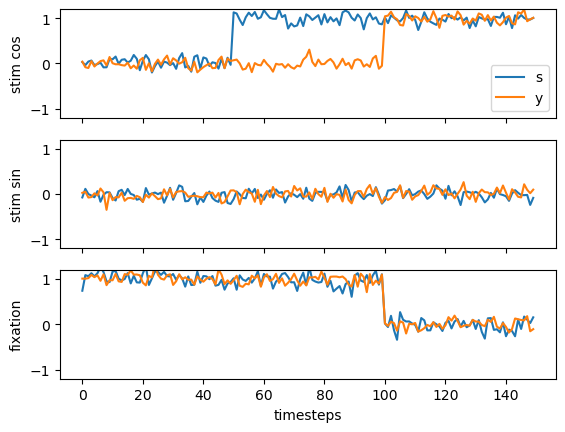

In [8]:
import plots
trial_ind = 0
plots.plot_sy(trials[trial_ind][-1])